This notebook takes borehole data from the East Kimberley and uses it to calculate the cementation values for solving Archie's Law.

Neil Symington
neil.symington@ga.gov.au

In [1]:
%matplotlib inline

In [2]:
from sqlite3 import dbapi2 as sqlite
import pandas as pd
import fiona
from shapely.geometry import Polygon, shape
from shapely import wkt
import numpy as np
from hydrogeol_utils import spatial_functions, AEM_utils, plotting_utils, borehole_utils
from geophys_utils._netcdf_point_utils import NetCDFPointUtils
import matplotlib.pyplot as plt
import os
import math
import sqlalchemy as db
from sqlalchemy import create_engine, event
import netCDF4
import yaml
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
from hydrogeol_utils.db_utils import makeCon, closeCon

In [3]:
def search(kword_dict, word):
    """
    A search function for finding if a keword
    exists as a list element within a dictionary entry
    
    @param kword_dict: dictionary with keywords
    @word: string
    returns
    the key for the entry if it exists or None if not
    """
    word = word.lower()
    for k in kword_dict:
        for v in kword_dict[k]:
            if word in v:
                return k
    return None

# Function for assigning stratigraphy above and below a point
# for a given downhole log/ layered model
def assign_stratigraphy_from_depth(df, depth, depth_columns, labels = ['cenozoic', 'mixed_signal', 'basement']):
    
    df['stratigraphy'] = ''
    
    if depth_columns == ['Depth']:
        
        for index, row in df.iterrows():
            if row['Depth'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif row['Depth'] == depth:
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df
    
    elif depth_columns == ['Depth_from', 'Depth_to']:
        for index, row in df.iterrows():
            if row['Depth_to'] < depth:
                df.at[index, 'stratigraphy'] = labels[0]
            elif (row['Depth_from'] < depth) & (row['Depth_to'] > depth):
                df.at[index, 'stratigraphy'] = labels[1]
            elif row['Depth_from'] > depth:
                df.at[index, 'stratigraphy'] = labels[2]
        return df
    
def resample_categorical_intervals(df, parameter_columns,
                                   interval_columns, new_intervals):
    # If the parameter input is a string and not a list make it a list
    if isinstance(parameter_columns, ("".__class__, u"".__class__)):
        parameter_columns = [parameter_columns]
    
    # Create a dataframe to add to
    df_resampled = pd.DataFrame(columns = interval_columns, data = new_intervals)
    
    for p in parameter_columns:
        
        df_resampled[p] = ''
        
        # Iterate through the new intervals
        for i, interval in enumerate(new_intervals):
            
            new_depth_from = interval[0]
            new_depth_to = interval[1]

            mask = (df[interval_columns[0]] < new_depth_to) & (df[interval_columns[1]] > new_depth_from)
            
            v = df[mask][p].mode()
            
            if len(v) == 1:
                
                df_resampled.at[i, p] = v.values[0]
            
            elif len(v) > 1:

                df_resampled.at[i, p] = 'transition'
    
    return df_resampled

  

In [4]:
# Extract data from the database

# Extract borehole data from the database

DB_PATH = r"C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite"

SPATIALITE_PATH = r'C:\mod_spatialite-NG-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)


connection = makeCon(DB_PATH)

# Open the borehole data as a pandas dataframe

df_header =pd.read_sql('select * from borehole', connection)


enos = df_header['borehole_id'].values


Connected to C:\Users\PCUser\Desktop\EK_data\Boreholes\East_Kimberley_borehole_data.sqlite. Temporary working copy created.


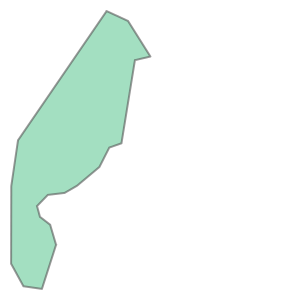

In [5]:
# AS we are only interested in the Keep Palaeovalley we will remove the bore that are outside of the
# Keep River polygon

# Open geometry for a shapefile. This will be used to filter the bores extracted from the database
c = fiona.open(r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\Neil\Keep_spatial\Keep_River_polygons.shp")
collection = [ shape(item['geometry']) for item in c ]
names = [item['properties']['Name'] for item in c]
polygons = [Polygon(pol.exterior.coords) for pol in collection] 

# Buffer by 5000 metres
OrdKeep = polygons[names.index('AEM_close')].buffer(10.)

# Now keep only bores that are within 
OrdKeep

In [6]:
# Now lets import the interpreted depths

# Bring in the interpreted depth to the base of the ceonozoic
infile = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\Bores_working\compilation\stratigraphy\EK_SonicStratigraphySummary.csv"

df_interp = pd.read_csv(infile)



df_header = borehole_utils.extract_sql_with_primary_key("borehole", ['*'],  connection, df_interp['borehole_id'].unique(),
                                                        verbose = True)

# Add borehole spatial data
df_interp = df_interp.merge(df_header[['borehole_id','Easting', 'Northing',
                                       'Ground_elevation_mAHD', 'geometry']],
                            on = 'borehole_id')

select t.* from borehole t where t.borehole_id in (635920,635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742,635743,635745,635746,635747,635748,635749);


In [7]:
# Keep only points within our area of interest

df_interp = df_interp[[wkt.loads(x).within(OrdKeep) for x in df_interp['geometry']]]
df_header =df_header[[wkt.loads(x).within(OrdKeep) for x in df_header['geometry']]]

# Get the enos
enos = df_interp['borehole_id'].unique()

utm_zone = 52
44 points in UTM bounding box: [500049.774, 8292360.686, 523640.009, 8316422.357]


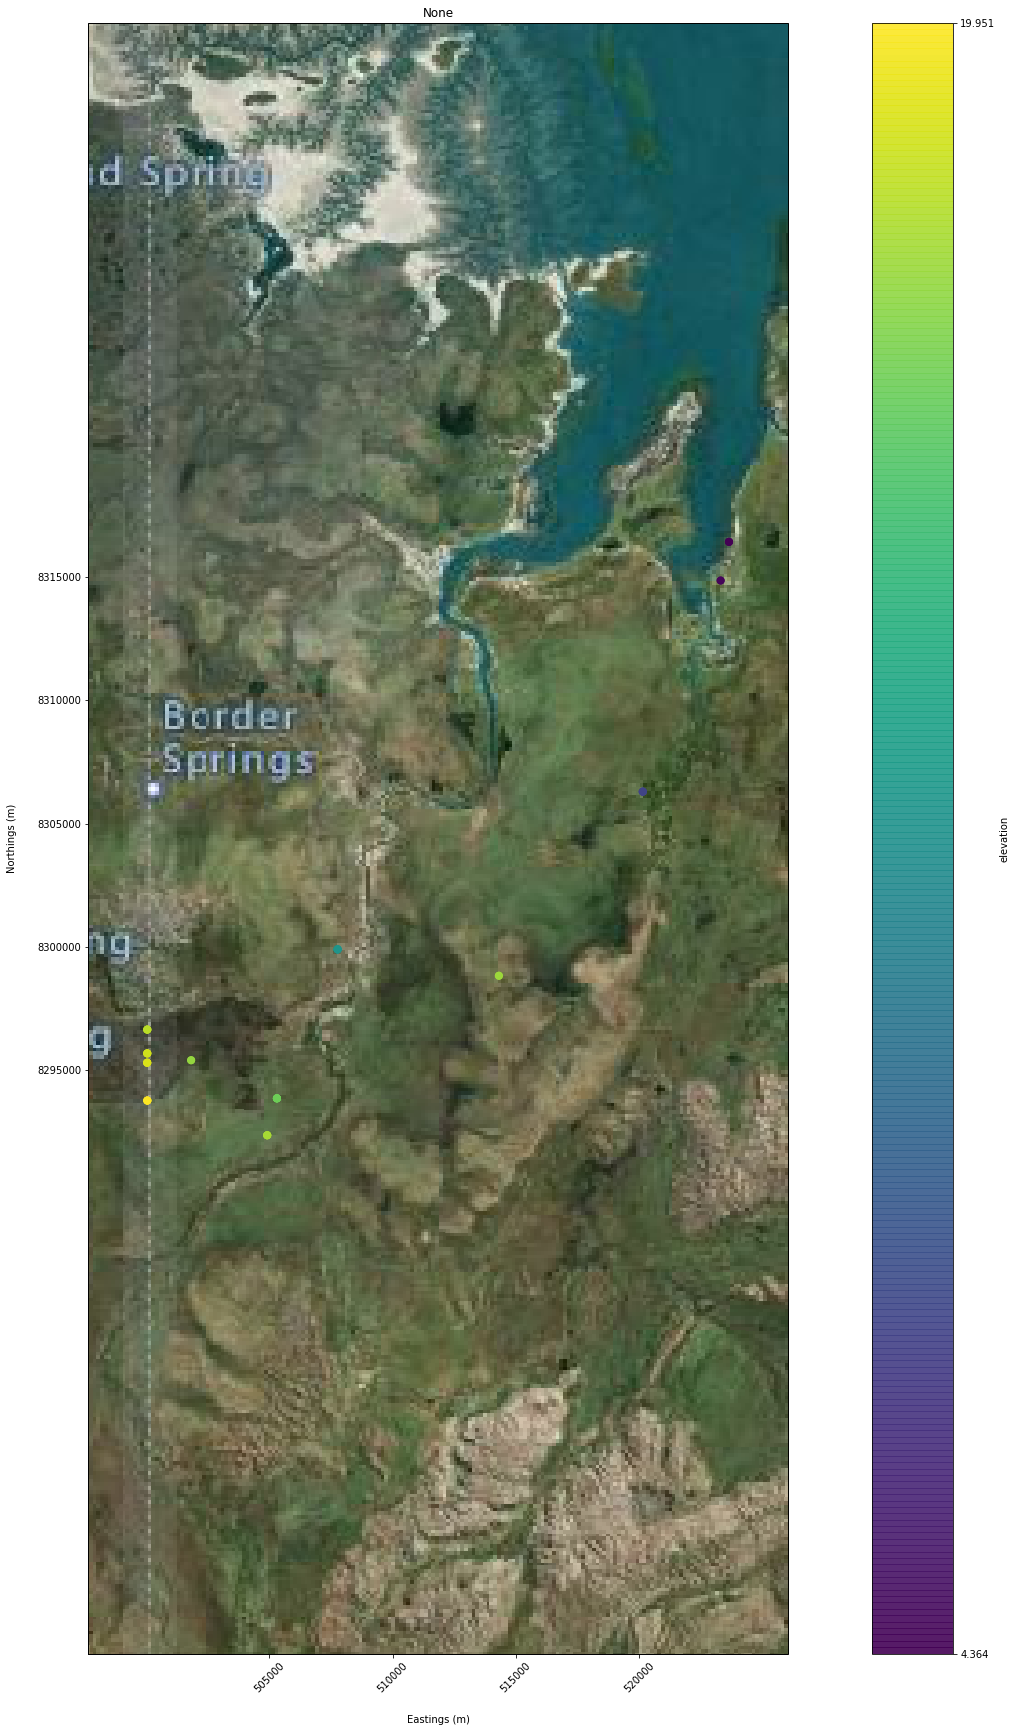

In [8]:
# Plot the bores on a basemap to get an idea of what datasets are available

utm_coords = df_interp[['Easting', 'Northing']].values

depth = df_interp['Ground_elevation_mAHD'].values

plotting_utils.plot_point_dataset(utm_coords, "EPSG:28352", depth,
                   colourbar_label = 'elevation', colour_scheme = 'viridis',
                    point_size=50)


In [9]:
# First import all the datasets based on our enos (primary key)


df_bNMR = borehole_utils.extract_sql_with_primary_key("boreholeNMR_data", ['Depth', 'Total_water_content',
                                                'Clay_water_content', 'Capillary_water_content',
                                               'Free_water_content', 'K_SDR', 'borehole_id'], connection, enos,
                                                verbose = True)
    

df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','borehole_id'], connection, enos,
                                                       verbose = True)



df_EC_pH = borehole_utils.extract_sql_with_primary_key("pore_fluid_EC_pH", 
                                                       ['Depth', 'EC', 'pH', 'borehole_id'],
                                                       connection, enos, verbose = True)

df_AEM = borehole_utils.extract_sql_with_primary_key("representative_AEM_bulk_conductivity", 
                                                       ['Depth_from', 'Depth_to', 'Bulk_conductivity', 'borehole_id'],
                                                       connection, enos, verbose = True)



select t.Depth, t.Total_water_content, t.Clay_water_content, t.Capillary_water_content, t.Free_water_content, t.K_SDR, t.borehole_id from boreholeNMR_data t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742);
select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742);
select t.Depth, t.EC, t.pH, t.borehole_id from pore_fluid_EC_pH t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742);
select t.Depth_from, t.Depth_to, t.Bulk_conductivity, t.borehole_id from representative_AEM_bulk_conductivity t where t.borehole_id in (635728,635729,635730,635733,635734,635735,635737,635738,635739,635740,635741,635742);


In [10]:
# Now we want all the datasets to be on the same depth intervals for the sake of creating a matrix
# from which we can investigate the relationship between multiple variables and stratigraphy

# Lets try 1 m intervals

layer_thickness = 1.

# The data will be appended to a dataframe called interpolated

df_interpolated = pd.DataFrame(columns = ['borehole_id', 'Depth_from', 'Depth_to',
                                         'Bulk_conductivity', 'Apparent_conductivity', "EC",
                                          'Total_water_content',
                                         'Clay_water_content', 'Capillary_water_content', 'Free_water_content',
                                          'stratigraphy'])

# Iterate through the bores

for index, row in df_header.iterrows():
    
    
    # First we want to find the max depth for the boreholes
    eno = row.borehole_id
    
    # Get the stratigraphy for the borehole
    df_strat_subset = borehole_utils.extract_by_primary_key(df_interp,
                                                           eno)
    
    
    # Round the interval values for ease of interpolation
    df_strat_subset.at[df_strat_subset.index,'Depth_from'] = df_strat_subset['Depth_from'].round()
    df_strat_subset.at[df_strat_subset.index,'Depth_to'] = df_strat_subset['Depth_to'].round()
    
    # Create
    
    
    min_depth = float(math.floor(df_interp[df_interp['borehole_id'] == eno]['Depth_from'].min()))

    max_depth = float(math.ceil(df_interp[df_interp['borehole_id'] == eno]['Depth_to'].max()))
    
    # Create depth from and depth to array
    
    depth_from = np.arange(min_depth, max_depth, layer_thickness)
    
    depth_to = np.arange(min_depth + layer_thickness, max_depth + layer_thickness, layer_thickness)
    

    new_intervals = pd.DataFrame(columns = ['Depth_from', 'Depth_to'],
                                 data = np.hstack((depth_from.reshape([-1,1]), depth_to.reshape([-1,1]))))

    # Now we want to create a new dataframe with the new intervals and the resampled stratigraphy
    
    df_resampled = resample_categorical_intervals(df_strat_subset, ['stratigraphy'],
                                   ['Depth_from', 'Depth_to'], new_intervals.values)
    
    
    if row.AEM_conductivity_available:
        
        df_cond_subset = borehole_utils.extract_by_primary_key(df_AEM,
                                                           eno)
        # Define variable column name(s)
        cols = ['Bulk_conductivity']
        # Interpolate
        df_newcond = spatial_functions.interpolate_layered_model(df_cond_subset,
                                                                 cols,
                                                                 ["Depth_from",
                                                                  "Depth_to"],
                                                                  new_intervals.copy())
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newcond[cols]
        
    
    # Subset the induction and gamma data
    
    # The exact way of dealing with the variable data coverage will be subset specific
    # Some bore will have on 
    if row.Induction_acquired:
        
        df_indgam_subset = borehole_utils.extract_by_primary_key(df_indgam,
                                                           eno)
        
        
        # Define variable column name(s)
        cols = ['Apparent_conductivity']
        
        # Interpolate this time using the point depth to interval fucntion
        df_newindgam = spatial_functions.interpolate_depths_to_intervals(df_indgam_subset,
                                                                         cols,
                                                                        new_intervals.values)
        
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newindgam[cols]
    
    # EC and pH
    if row.EC_pH_acquired:
        
        df_ECpH_subset = borehole_utils.extract_by_primary_key(df_EC_pH,
                                                           eno)
        
        # Define variable column name(s)
        cols = ['EC']
        
        # Interpolate this time using the point depth to interval fucntion
        df_newEC = spatial_functions.interpolate_depths_to_intervals(df_ECpH_subset,
                                                                         cols,
                                                                         new_intervals.values)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newEC[cols]
    
    # Borehole NMR
    if row.Javelin_acquired:
        
        df_bNMR_subset = borehole_utils.extract_by_primary_key(df_bNMR,
                                                           eno)
        # Define variable column name(s)
        cols = ['Total_water_content', 'Clay_water_content',
                'Capillary_water_content', 'Free_water_content']
        # Interpolate
        df_newbNMR = spatial_functions.interpolate_depths_to_intervals(df_bNMR_subset,
                                                                         cols,
                                                                         new_intervals.values)
        # Add as a new column to the lith subset frame
        df_resampled[cols] = df_newbNMR[cols]
    
   
    
    # Add the borehole id
    df_resampled['borehole_id'] = eno
    
    # Append to dataframe
    df_interpolated = df_interpolated.append(df_resampled)
        
        
# Remove any columns without any entries

df_interpolated.dropna(axis = 1, how = 'all', inplace = True)

df_interpolated.reset_index(inplace = True, drop = True)

df_interpolated = df_interpolated[df_interpolated['stratigraphy'] != ''] 

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


In [11]:
# Now keep only intervals with bnmr, ec, apparent conductivity and stratigraphy

df_interpolated_subset = df_interpolated.dropna(subset = ['Total_water_content',
                                                         'EC', #
                                                          'Apparent_conductivity',
                                                         #'Bulk_conductivity'
                                                         ], how = 'any')

outdir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\results"

outfile = os.path.join(outdir, "OrdKeep_boreholes_interpolated_EC_bulkCond_bNMR.csv")

#df_interpolated_subset.to_csv(outfile)


In [12]:
# NOw we want our stratigraphy to be in a numerical form

strat_dict = {'Cenozoic sediments':0,
              'Permo-Carboniferous':1,
              'Milligans Formation':2}

df_interpolated['strat_ind'] = [strat_dict[s] for s in df_interpolated['stratigraphy']]

In [13]:
# Now we want to claculate m-values (cementation factos) for the various units so we can
# plug values into Archie's LAw

# Solve for m

log_cond = np.log10(df_interpolated_subset['Apparent_conductivity'].values)
log_EC = np.log10(df_interpolated_subset['EC'].values)
log_poro = np.log10(df_interpolated_subset['Free_water_content']).values

df_interpolated_subset['m'] = (log_cond - log_EC)/(log_poro)

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


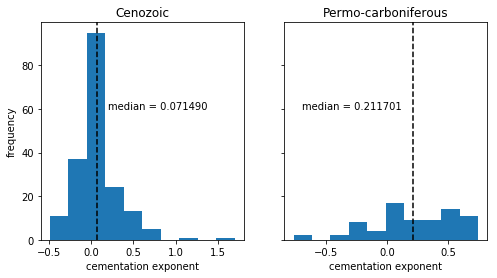

In [14]:
# PLot all the m values

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4), sharey = True)

mask1 = df_interpolated_subset['stratigraphy'] == 'Cenozoic sediments'

ax1.hist(df_interpolated_subset[mask1]['m'])

mask2 = df_interpolated_subset['stratigraphy'] == 'Permo-Carboniferous'

ax2.hist(df_interpolated_subset[mask2]['m'])

ax1.set_xlabel('cementation exponent')

ax2.set_xlabel('cementation exponent')
ax1.set_ylabel('frequency')

ax1.set_title('Cenozoic')
ax2.set_title('Permo-carboniferous')

ax1.axvline(x=0.071490, linestyle = '--', c = 'k')
ax2.axvline(x=0.211701, linestyle = '--', c = 'k')

ax1.text(0.2, 60, 'median = 0.071490')
ax2.text(-0.7, 60, 'median = 0.211701')

plt.savefig(r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\SANDPIT\Keep_River\draft_report\Figures\cementation_population.png')

In [15]:
# Now get summary statistics

print('cenozoic')

print(df_interpolated_subset[mask1]['m'].describe())
print(' ')
print('permo-carboniferous')

print(df_interpolated_subset[mask2]['m'].describe())

cenozoic
count    187.000000
mean       0.090523
std        0.267569
min       -0.485929
25%       -0.055092
50%        0.071490
75%        0.167059
max        1.695924
Name: m, dtype: float64
 
permo-carboniferous
count    76.000000
mean      0.216398
std       0.333018
min      -0.769863
25%       0.037477
50%       0.211701
75%       0.491173
max       0.746748
Name: m, dtype: float64


In [16]:
df_interpolated_subset['borehole_id']

4      635728
6      635728
7      635728
8      635728
9      635728
10     635728
12     635728
13     635728
14     635728
15     635728
16     635728
18     635728
19     635728
20     635728
21     635728
22     635728
24     635728
25     635728
26     635728
27     635728
28     635728
29     635728
30     635728
31     635728
32     635728
33     635728
34     635728
35     635728
36     635728
37     635728
        ...  
477    635741
478    635741
479    635741
480    635741
481    635741
482    635741
498    635742
500    635742
501    635742
502    635742
503    635742
504    635742
505    635742
506    635742
507    635742
508    635742
509    635742
510    635742
511    635742
512    635742
513    635742
514    635742
515    635742
516    635742
517    635742
518    635742
519    635742
520    635742
521    635742
522    635742
Name: borehole_id, Length: 271, dtype: object

C:\Users\u77932\AppData\Local\Continuum\anaconda3\envs\hydrogeol_utils\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


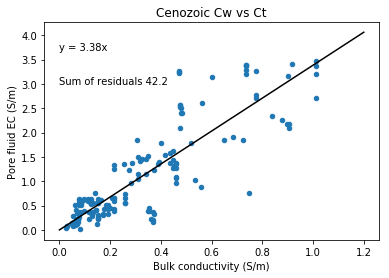

In [22]:
# WE are now going to investigate the empirical relationship between EC and conductivity

# Try removing outliers bore where the AEM inversion has not fit properly

mask_ = df_interpolated_subset[mask1]['borehole_id'] != 635730

ax1 = df_interpolated_subset[mask1][mask_].plot.scatter(x = 'Bulk_conductivity',
                                          y = 'EC')

x = df_interpolated_subset[mask1][mask_]['Bulk_conductivity']
y = df_interpolated_subset[mask1][mask_]['EC']

# We use a least square model
x = x[:,np.newaxis]

# Make x a column vector
slope, residuals, _, _ = np.linalg.lstsq(x, y)

newx = np.array([0,1.2])
newy = slope *newx

ax1.plot(newx, newy, 'k')

ax1.set_xlabel('Bulk conductivity (S/m)')
ax1.set_ylabel('Pore fluid EC (S/m)')

ax1.set_title('Cenozoic Cw vs Ct')

ax1.text(0,3.7, 'y = ' + str((round(slope[0],2))) + 'x')
ax1.text(0,3.0, 'Sum of residuals = '+ str(round(residuals[0], 1)))

plt.savefig(r'\\prod.lan\active\proj\futurex\East_Kimberley\Working\SharedWorkspace\OrdKeep_water_quality\results\bulk_cond_vs_EC_.png',
           dpi= 350)

plt.show()

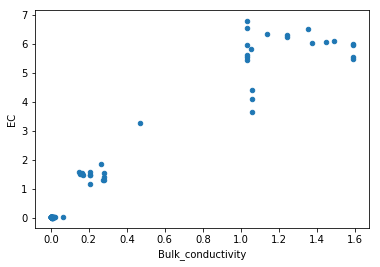

In [35]:
df_interpolated_subset[mask2].plot.scatter(x = 'Bulk_conductivity',
                                          y = 'EC')

In [41]:
df_thin.shape

(36, 9)